In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely import wkt
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import re

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import model_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.display.float_format = '{:40,.4f}'.format
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
%matplotlib inline

# Predicting building demolition risk in Philadelphia's residential neighbourhoods, 2018-2021
## Introduction

Increasing demand for urban amenities in Philadelphia has put a growing proportion of the city’s buildings at risk of demolition. Between 2009 and 2019, the number of demolition permits issued to private developers increased by 255%, overtaking the number of City-mandated demolition permits — which target neglected structures — in 2018 (Briggs, 2019). Several of these permits have been issued for historic and cultural landmarks, enabled by Philadelphia’s lack of protection for historic buildings (Blumgart, 2019; Maule, 2019; Saffron, 2021). In addition, private demolitions are concentrated in gentrifying neighbourhoods (Blumgart, 2018), further reducing affordable housing stock and thus increasing the displacement risk of original residents (Charles, 2013). 

To protect Philadelphia’s historic fabric and affordable housing supply, planners and preservation advocates need to anticipate which buildings are likely to be demolished in the coming years. Using demolition data from 2018-2021, open property data from the City of Philadelphia, and U.S. Census data, this report evaluates the utility of two approaches to predicting building-level demolition risk: principal component logistic regression and random forest classification. The aim of this report is to identify which of these approaches policymakers should take to predict building demolition risk. 

## Literature review

### Approaches to predicting demolition risk

Models predicting the demolition risk of individual buildings have been estimated for other cities, all of which take a similar approach (Weber et al., 2006; Dye and McMillen, 2007; Charles, 2012; Dubé et al., 2018). A time frame of study is identified, and then, using the characteristics of buildings and their surrounding neighbourhoods at the start of this period, logistic regression is used to classify whether a building would be demolished within the study period. 

While the interpretability of logistic regression models lends them explanatory utility, these models cannot fully account for the interactions between independent variables, reducing their predictive power (Reades et al., 2018). This is an especially pertinent limitation for modelling demolition risk, as neighbourhood-level and building-level characteristics tend to interact (Weber et al., 2006). This report thus tests machine-learning classification approaches that can account for these relationships. 

### Predictors of demolition risk

Building demolition in gentrifying neighbourhoods is a response to rent gaps: situations where the value of a property (plus the cost of its demolition) is worth less than the land on which it is located, resulting in an opportunity for redevelopment (Smith, 1979; Munneke, 1996). As such, the demolition risk for individual properties is linked to both characteristics of properties themselves and characteristics of their surrounding neighbourhoods. In studies of residential building demolition, the following property characteristics have been linked to increased demolition risk — all of which decrease property values (Weber et al., 2006; Charles, 2012):
- Old building age
- Low quality of construction
- High parcel area
- Low market value

The following neighbourhood characteristics are also associated with higher building demolition risk (Dye and McMillen, 2007; Charles, 2012):
- Proximity to city centre
- Public transport access
- Median income (at start of study period, and increase in preceding 10-20 years)
- Decrease in the proportions of Black and Hispanic residents (in preceding 10-20 years)

All of these variables were included in the models estimated for this report. 

However, these studies were conducted in other cities, which may have different indicators of redevelopment demand than Philadelphia. Therefore, this report also includes indicators of redevelopment activity in Philadelphia, namely the percentage of White residents and percentage of residents with a Bachelor's degree or higher, as well as the change in each proportion in the preceding 10-20 years (Ding et al., 2016).

## Research Question

**How can planners predict the demolition risk of individual buildings in Philadelphia?**


## Presentation of Data
### Data collection
Given the large number of properties included in the dataset (over 500,000) and the number of features attached to each property (42), executing the code for data collection takes a considerable amount of time. This section therefore omits the full code, instead outlining the data collection process in detail. The code described in this section can be found in a separate notebook on [Github](https://github.com/caranvr/DSSS-predicting-demolition/blob/main/data-collection-code.ipynb).

#### Property characteristics

The City of Philadelphia's Office of Property Assessments (OPA) maintains a regularly updated, georeferenced database of city properties, which contains building characteristics used to assess property tax rates. Due to the large size of the dataset, this database was accessed through an API call. Based on property characteristics found to predict demolition risk in previous studies, the following (non-identifying) features were selected:
- **interior_condition**: a numeric code representing the quality of a property's interior. Properties are rated on a scale of 1 to 7, with 1 corresponding to new construction and 7 corresponding to "structurally compromised" (City of Philadelphia, 2021). A value of 0 indicates vacant land. 
- **exterior_condition**: a numeric code representing the property's external appearance, using the same scale as *interior_condition*. 
- **total_area**: the total area of the property.
- **year_built**: the year the property was built.

To match properties to Census tracts and find distances to relevant attractions, the latitude and longitude of each property were requested as well. In addition, **category_code_description** was selected, as Weber et al. (2006) only looked at single-family residential property demolition. Commercial, industrial, or multi-family residential properties may have different predictors of demolition risk. 

The most comprehensive property dataset is the most recent one. However, for 86.3% of properties with an associated demolition permit, the property assessment on file is from prior to demolition, or the building has not yet been demolished. The remaining properties have been re-assessed since their demolition and are now listed as vacant land. Since the model includes building characteristics, and these features are missing for properties classed as 'Vacant Land', all properties in this category were dropped from the dataset. The remaining properties were matched against the demolition dataset to identify whether or not a demolition permit was attached to them after 2018. 

A separate OPA dataset was used to find each property's market value in 2018. 

#### Demolitions

The City of Philadelphia's Licenses and Inspections Department maintains a database of all demolition permits in the city issued since 2007. The addresses associated with private demolition permits from 2018-2021 were extracted, as public demolitions are more reflective of structural issues than consumer demand (Weber et al., 2006). A binary field encoding whether an address was associated with a demolition permit was added, with 0 representing the absence of a demolition permit and 1 representing its presence. 

#### Distance attributes

In line with Ding et al. (2016), City Hall was used as a proxy for the city centre. The geopandas library was used to calculate the distance from each property to City Hall. 

To find the distance from each property to its closest public transport stop, shapefiles of commuter rail, subway, and trolley stops were downloaded and concatenated into one dataframe. This dataframe was then converted into a binary search tree using scipy's cKDTree method, which allowed for quick spatial querying. 

#### Neighbourhood attributes

Due to data availability, neighbourhoods were defined as U.S. Census tracts, which have an average population of 4,000 residents (Weber et al., 2006; Oka and Wong, 2016). The U.S. Census American Community Survey (ACS) 2013-18 5-Year Estimates were used for 2018 demographic variables, while the Longitudinal Tract Database (LTDB) — which matches 2000 Census data to post-2010 Census tract boundaries (Logan et al., 2014) — was used for the same variables in 2000. 

For comparison to the LTDB variables, ACS columns related to higher education were summed. Properties were then spatially matched to Census tracts.

### Data cleaning

In [2]:
#Load in processed dataset in chunks to save memory
chunks = []
chunked_df = pd.read_csv('geo_props_final.csv', chunksize=40000)

for chunk in chunked_df:
    chunks.append(chunk)

df = pd.concat(chunks)

In [3]:
df.set_index('parcel_number', inplace=True)
df.head()

,lng,lat,location,category_code_description,interior_condition,exterior_condition,total_area,year_built,demolition,market_value,geometry,dist_city_hall,dist_to_transport,index_right,TRACTCE10,NAME10,B01001_001E,B03002_003E,B03002_004E,B03001_003E,B25003_001E,B25003_002E,B25003_003E,B15002_001E,B19013_001E,COL18,POP00,NHWHT00,NHBLK00,HISP00,HU00,OWN00,RENT00,AG25UP00,COL00,HINC00
parcel_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11001660,-75.1485,39.9314,222 WHARTON ST,Single Family,4.0000,4.0000,"1,622.7000",1960,0,"212,700.0000",POINT (2697955.826447476 228629.0357761488),1.6460,1.0402,42101002702,2702,27.0200,4590,3859,115,366,1891,1345,546,3700,"66,042.0000",1443,"3,715.0001","1,958.8888",809.1695,331.3326,"1,700.3232",808.1993,635.0137,"2,356.6819",317.7494,"36,532.2509"
11001670,-75.1486,39.9315,224 WHARTON ST,Single Family,4.0000,4.0000,"1,624.5000",1960,0,"212,800.0000",POINT (2697937.837638319 228631.0213364959),1.6439,1.0369,42101002702,2702,27.0200,4590,3859,115,366,1891,1345,546,3700,"66,042.0000",1443,"3,715.0001","1,958.8888",809.1695,331.3326,"1,700.3232",808.1993,635.0137,"2,356.6819",317.7494,"36,532.2509"
11001680,-75.1487,39.9315,226 WHARTON ST,Single Family,4.0000,4.0000,"1,627.2000",1960,0,"212,800.0000",POINT (2697919.806834467 228634.3710673039),1.6417,1.0334,42101002702,2702,27.0200,4590,3859,115,366,1891,1345,546,3700,"66,042.0000",1443,"3,715.0001","1,958.8888",809.1695,331.3326,"1,700.3232",808.1993,635.0137,"2,356.6819",317.7494,"36,532.2509"
11001690,-75.1487,39.9315,228 WHARTON ST,Single Family,4.0000,4.0000,"1,683.9000",1960,0,"215,000.0000",POINT (2697902.782262222 228636.389107908),1.6397,1.0302,42101002702,2702,27.0200,4590,3859,115,366,1891,1345,546,3700,"66,042.0000",1443,"3,715.0001","1,958.8888",809.1695,331.3326,"1,700.3232",808.1993,635.0137,"2,356.6819",317.7494,"36,532.2509"
11003500,-75.1471,39.9310,108 SEARS ST,Single Family,4.0000,4.0000,426.5600,1920,0,"140,800.0000",POINT (2698373.720296731 228474.826438891),1.7122,1.1244,42101002702,2702,27.0200,4590,3859,115,366,1891,1345,546,3700,"66,042.0000",1443,"3,715.0001","1,958.8888",809.1695,331.3326,"1,700.3232",808.1993,635.0137,"2,356.6819",317.7494,"36,532.2509"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534304 entries, 11001660 to 882150800
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   lng                        534304 non-null  float64
 1   lat                        534304 non-null  float64
 2   location                   534304 non-null  object 
 3   category_code_description  534304 non-null  object 
 4   interior_condition         533936 non-null  float64
 5   exterior_condition         534253 non-null  float64
 6   total_area                 534304 non-null  float64
 7   year_built                 534304 non-null  int64  
 8   demolition                 534304 non-null  int64  
 9   market_value               532712 non-null  float64
 10  geometry                   534304 non-null  object 
 11  dist_city_hall             534304 non-null  float64
 12  dist_to_transport          534304 non-null  float64
 13  index_right        

Columns from the 2013-18 ACS were renamed for easier interpretation.

In [5]:
df.rename(columns={
    'B01001_001E': 'POP18',
    'B03002_003E': 'NHWHT18',
    'B03002_004E': 'NHBLK18',
    'B03001_003E': 'HISP18',
    'B25003_001E': 'HU18',
    'B25003_002E': 'OWN18',
    'B25003_003E': 'RENT18',
    'B15002_001E': 'AG25UP18',
    'B19013_001E': 'HINC18'
}, inplace=True)

Columns were then inspected for null values, which are not accepted in the classification methods used for this analysis.

In [6]:
#Check for columns where most values are null
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[:5]

,Total,Percent
market_value,1592,0.2980
interior_condition,368,0.0689
HINC18,71,0.0133
exterior_condition,51,0.0095
HINC00,0,0.0000


Only four columns have missing data, and the percentage of rows in each column with missing values is small. Missing values could therefore be dropped or imputed without a significant impact on model performance.

Given that interior_condition and exterior_condition are ordinal scales, the only option for imputing missing values in these columns is mode imputation. Mode imputation for these features may be inaccurate for individual properties, even if modal values from the same Census tract rather than the whole city were used, as buildings can vary significantly even within neighbourhoods. Thus, properties with missing values for these columns were dropped.

In [7]:
missing_bldgs = df.loc[
    (df['interior_condition'].isnull()) |
    (df['exterior_condition'].isnull())
]

print(f'{missing_bldgs.shape[0]} properties will be dropped')

370 properties will be dropped


In [8]:
df.drop(index=missing_bldgs.index, inplace=True)

Market value is also a function of property-level characteristics, which would not be taken into consideration during imputation. Properties with missing market values were thus dropped.

In [9]:
missing_values = df.loc[
    df['market_value'].isnull()
]

print(f'{missing_values.shape[0]} properties will be dropped')

1523 properties will be dropped


In [10]:
df.drop(index=missing_values.index, inplace=True)

Properties missing a Census tract median income for 2018 were all in one of two Census tracts, meaning that two Census tracts were missing 2013-18 median income data:

In [11]:
pd.DataFrame(df.loc[
    df['HINC18'].isnull()
].groupby('TRACTCE10').size().sort_values(ascending=False)).rename(columns={0: 'Missing values'})

,Missing values
TRACTCE10,
989100,39
980100,32


Given that only 71 properties were affected and in two Census tracts, missing values were imputed with the median income in Philadelphia. 

In [12]:
df['HINC18'] = df['HINC18'].fillna(df['HINC18'].median())

The dataset was then checked for invalid values in the 'year_built' column. Properties with a value of 0 in this column were dropped.    

In [13]:
missing_years = df.loc[
    df['year_built'] == 0
]

print(f'{missing_years.shape[0]} properties will be dropped')

1731 properties will be dropped


In [14]:
df.drop(index=missing_years.index, inplace=True)

Lastly, columns that represent total populations and housing units for Census tracts were checked for zeroes, as counts of population grorups and housing unit types were later converted to percentages. Total counts of zero would result in null values, so properties in these Census tracts had to be dropped. 

In [15]:
zero_totals = df.loc[
    (df['HU00'] == 0) |
    (df['HU18'] == 0) |
    (df['POP00'] == 0) |
    (df['POP18'] == 0)
]

print(f'{zero_totals.shape[0]} properties will be dropped')

38 properties will be dropped


In [16]:
df.drop(index=zero_totals.index, inplace=True)

In [17]:
df.shape

(530642, 36)

#### Feature transformation

For comparability between Census tracts, raw counts of residents or households in each demographic group were converted to percentages of a total, either of residents or housing units. (In line with U.S. Census practices, the number of residents with a Bachelor's degree or above was calculated as the proportion of residents _over 25_ with a Bachelor's degree or above.) 

In [18]:
#Convert selected features to percentages
def convert_to_pc(df, cols, denominator):
    for c in cols:
        df[c] = (df[c]/df[denominator])*100
    return df

pc_cols = {
    'POP00': ['NHWHT00', 'NHBLK00', 'HISP00'], #key is denominator, value is list of columns to divide by denominator
    'HU00': ['OWN00', 'RENT00'],
    'AG25UP00': ['COL00'],
    'POP18': ['NHWHT18', 'NHBLK18', 'HISP18'],
    'HU18': ['OWN18', 'RENT18'],
    'AG25UP18': ['COL18']
}

for k,v in pc_cols.items():
    df = convert_to_pc(df,v,k)

To measure change in neighbourhood characteristics, columns corresponding to 2000 were converted to the percentage point difference (for percentage columns) or percentage change (for total columns) in tract values from 2000 to 2018.

In [19]:
#Convert 2000 columns to percentage change from 2000-2018

#Lookup for fields encoding percentage point difference from 2000 to 2018
pc_diff = {
    'NHWHT18': 'NHWHT00',
    'NHBLK18': 'NHBLK00',
    'HISP18': 'HISP00',
    'OWN18': 'OWN00',
    'RENT18': 'RENT00',
    'COL18': 'COL00'
}

#Lookup for fields encoding percentage point change from 2000 to 2018 (counts)
pc_change = {
    'POP18': 'POP00', #total population
    'HU18': 'HU00', #total housing units
    'AG25UP18': 'AG25UP00', #25+ population
    'HINC18': 'HINC00' #median household income
}

#Replace 2000 columns with the percentage change or difference from 2000 to 2018
for k,v in pc_diff.items():
    df[v] = df[k] - df[v]

for k,v in pc_change.items():
    df[v] = ((df[k] - df[v])/df[v])*100

For interpretability purposes, the 'year_built' column was converted so that it would represent the age of a building in 2018.

In [20]:
df['year_built'] = 2018 - df['year_built']

Multicollinearity may be especially strong between features encoding interior and exterior condition ratings, considering that both measure overall building maintenance. Therefore, a single measure encoding the sum of interior and exterior condition ratings was created. This variable takes values from 2 to 14, with 2 encoding new construction and 14 representing structural compromise. 

In [21]:
df['building_condition'] = df['interior_condition'] + df['exterior_condition']

In [22]:
df.drop(columns=['interior_condition', 'exterior_condition'], inplace=True)

The 'building_condition' column and the 'category_code_description' column were converted to category data types, and then to dummy variables.

In [23]:
cat_cols = ['category_code_description', 'building_condition']

for c in cat_cols:
    if c == 'category_code_description':
        df[c] = df[c].astype('category')
    else:
        df[c] = df[c].astype(pd.UInt16Dtype()).astype('category')

In [24]:
id_cols = ['lng', 'lat', 'geometry', 'location', 'index_right', 'TRACTCE10', 'NAME10']
var_cols = [c for c in df.columns.values if c not in id_cols]

df_var = df[var_cols].copy()
df_var = pd.get_dummies(df_var)

### Exploratory data analysis

#### Class balance


To determine which classification approach would be appropriate, the class balance of the dataset — the proportion of properties with an associated demolition permit — was examined.

In [25]:
pd.DataFrame(df_var.groupby('demolition').size()).rename(columns={0:'Properties'})

,Properties
demolition,
0,529786
1,856


The vast majority (99.84%) of properties in Philadelphia did not have an associated demolition permit from after 2018, a heavy imbalance that would lead to poor classification of demolitions. Common approaches to such an imbalance include undersampling the majority class or oversampling the minority class (Ruiz-Gazen and Villa, 2008). However, artificially balancing the dataset can lead to suboptimal model performance on real-world, class-imbalanceed data. 

Thus, to balance out the dataset, only properties in Census tracts with high demolition rates were included in the analysis. This way, the algorithm would be trained on neighbourhoods that face higher overall demolition risk — where predictive analytics would be most useful — but the class balance would even out slightly. For simplicity, the upper quartile of demolition counts per tract was calculated, and properties in Census tracts with demolition counts above this cutoff were included.

In [26]:
#Going back to original df with identifiers
df.rename(columns={'index_right': 'census_tract'}, inplace=True)
demolitions_by_tract = pd.DataFrame(df.groupby(['census_tract', 'demolition']).size()).rename(columns={0: 'Properties'})

In [27]:
demolitions_by_tract.xs(1, level='demolition').describe().rename(columns={'Properties': 'Demolitions'})

,Demolitions
count,198.0000
mean,4.3232
std,5.3256
min,1.0000
25%,1.0000
50%,2.0000
75%,6.0000
max,29.0000


In [28]:
#Find tracts with high numbers of demolitions
high_dem_tracts = demolitions_by_tract.xs(1, level='demolition').loc[
    demolitions_by_tract.xs(1, level='demolition')['Properties'] >= 6
].index.values

#Isolate df_var to only parcels in high-demolition tracts
high_dem_parcels = df.loc[df['census_tract'].isin(high_dem_tracts)].index

df_var = df_var.loc[high_dem_parcels]

In [29]:
df_var.shape

(71820, 45)

In [30]:
df_var.groupby('demolition').size()

demolition
0    71233
1      587
dtype: int64

A slightly higher proportion of properties in the filtered dataset have associated demolition permits than in the full dataset (0.8% vs. 0.16%). However, the class imbalance is still extreme, and therefore still needs to be accounted for in the classification process.

#### Mapping the data

Figure 1 shows properties from the filtered dataset with an associated demolition permit, all of which are in Census tracts with high demolition counts relative to other tracts. These tracts are largely bordering the city centre, with some tracts in University City (in West Philadelphia, an area with high redevelopment) and one in the northwest. 

In [31]:
df['geometry'] = df['geometry'].apply(wkt.loads)

In [32]:
gdf = gpd.GeoDataFrame(df.loc[df['census_tract'].isin(high_dem_tracts)], geometry='geometry', crs='epsg:2272')
gdf.to_crs('epsg:3857', inplace=True)

Text(0.5, 1.0, 'Figure 1. Demolitions in Philadelphia, 2018-21')

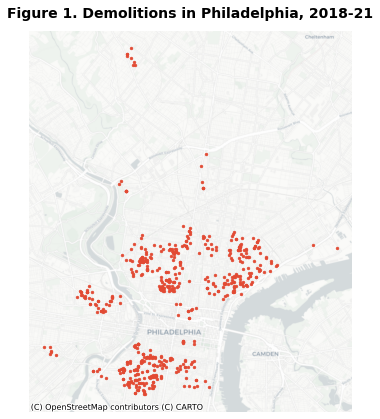

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
gdf[gdf['demolition']==1].plot(ax=ax, markersize=8)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Figure 1. Demolitions in Philadelphia, 2018-21', fontdict={'fontsize': 14, 'fontweight': 'bold'}, pad=13)

#### Summary statistics



In [34]:
cats_w_demo = [c for c in df_var.columns.values if re.search('category_code_description|building_condition|demolition', c)]
df_var.drop(columns=cats_w_demo).describe()

,total_area,year_built,market_value,dist_city_hall,dist_to_transport,POP18,NHWHT18,NHBLK18,HISP18,HU18,OWN18,RENT18,AG25UP18,HINC18,COL18,POP00,NHWHT00,NHBLK00,HISP00,HU00,OWN00,RENT00,AG25UP00,COL00,HINC00
count,"71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000","71,820.0000"
mean,"2,046.1325",88.6468,"258,708.4779",2.0394,0.3789,"4,148.8891",39.3663,42.4178,10.2044,"1,702.0858",47.2565,52.7435,"2,968.9811","51,718.2349",37.2732,8.8800,11.0769,-16.5884,2.1989,-5.9505,4.9898,13.4707,24.1853,23.0329,34.8283
std,"28,028.7235",36.7788,"1,949,311.5172",1.1072,0.2541,"1,484.5804",27.8211,31.6255,13.0181,635.4765,14.0775,14.0775,"1,259.4487","28,500.0138",23.1767,27.0917,15.4437,17.4765,4.8139,24.3152,8.8025,11.5094,35.2277,15.1050,60.5345
min,0.0000,1.0000,0.0000,0.1253,0.0033,"1,207.0000",0.0517,1.2255,0.9053,562.0000,5.0938,31.7152,674.0000,"11,497.0000",4.0918,-26.9100,-15.7737,-62.3803,-17.2433,-36.4009,-15.8932,-12.5080,-50.6589,-1.5427,-54.4554
25%,700.0000,93.0000,"61,900.0000",1.3055,0.1749,"3,030.0000",9.3182,11.5204,4.3049,"1,114.0000",40.2346,41.5121,"1,967.0000","25,000.0000",15.5179,-6.3166,0.9237,-27.0037,0.3116,-21.5760,-0.5782,7.7939,3.2859,8.7311,-17.4504
50%,934.6300,98.0000,"121,900.0000",1.8935,0.3213,"4,080.0000",34.9919,33.5255,7.0423,"1,572.0000",49.2462,50.7538,"2,642.0000","42,500.0000",36.1235,1.6745,7.0572,-12.1265,2.4942,-11.8468,3.5361,12.7321,17.0935,26.3929,30.4983
75%,"1,248.0000",103.0000,"264,100.0000",2.5155,0.5333,"5,026.0000",64.4025,73.0363,9.7665,"2,165.0000",58.4879,59.7654,"3,741.0000","74,261.0000",58.6508,16.3459,18.1004,-3.8590,4.3513,6.7343,8.9800,20.8779,40.5018,33.1876,57.5796
max,"5,999,724.0000",366.0000,"307,640,000.0000",7.4297,1.4446,"6,941.0000",89.5827,94.3079,76.5060,"2,900.0000",68.2848,94.9062,"5,524.0000","111,467.0000",86.0438,106.3105,55.5352,16.2740,12.5337,92.6110,26.3012,51.2294,148.0769,60.3583,195.6825


A basic logistic regression model could not include all predictors; as shown in Figure 1, there is a high degree of multicollinearity between features, especially between neighbourhood characteristics. 

Text(0.5, 1.0, 'Figure 2. Correlations between predictors')

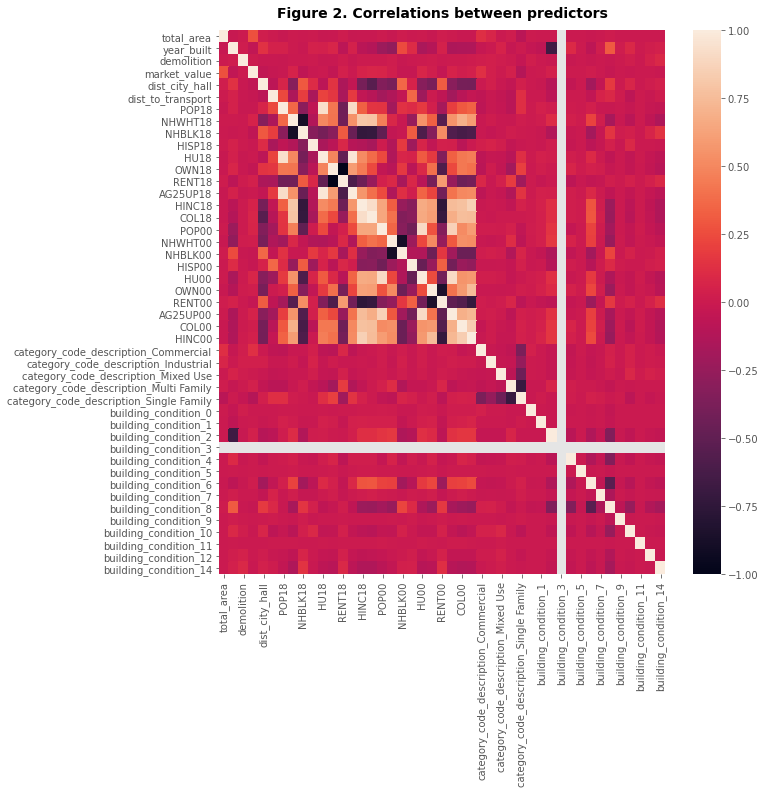

In [35]:
#Correlation matrix
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df_var.corr(), vmin=-1, vmax=1)
heatmap.set_title('Figure 2. Correlations between predictors', fontdict={'fontsize': 14, 'fontweight': 'bold'}, pad=13)

Since the 'building_condition_3' dummy variable had null correlations with all other variables, including the demolition dummy variable, this column was dropped from the dataset. 

In [36]:
df_var.drop(columns='building_condition_3', inplace=True)

## Methodology

Two approaches to predict whether a building would be demolished were used: logistic regression (LR) using outputs from Principal Components Analysis (PCA), and random forest (RF) classification. Both of these approaches account for the correlations and interactions observed between building and neighbourhood characteristics (Weber et al., 2006). 

Given a set of predictors, PCA produces features (components) that are linear combinations of the original predictors, and are orthogonal to each other (Jolliffe and Cadima, 2016). Each component accounts for a certain percentage of variance in the original dataset, with most variance explained by only _k_ of the _n_ components produced. Every observation in the dataset receives a score for each component, allowing a selection of components to be used as inputs to classification models. This in turn enables information from correlated variables to be used for prediction.

RF algorithms are built on decision trees, each of which identifies different splitting points based on feature values. Each split subsets observations into distinct groups. Given the possibility of various "branches", these decision trees take interactions between predictors into account by default. Moreover, the number of trees produced by the RF algorithm prevents the risk of over-fitting presented by a single classification tree.  

To aid in model estimation and validation, the dataset was split into predictors and labels. 

In [37]:
X = df_var.drop(columns='demolition')
Y = df_var['demolition']

### 1. Extracting principal components

Only continuous features were transformed into principal components, as categorical features are unsuited to PCA (Nguyen and Holmes, 2019).

In [38]:
#Isolate continous variables
categoricals = [c for c in X.columns.values if re.search('category_code_description|building_condition', c)]
X_pc = X.drop(columns=categoricals).values

#Rescale continuous variables
X_pc = StandardScaler().fit_transform(X_pc)

#Find components
pca = PCA(random_state=51)
# fit the components
X_new_components = pca.fit_transform(X_pc)

Text(0.5, 1.0, 'Figure 3. Principal components vs. eigenvalues')

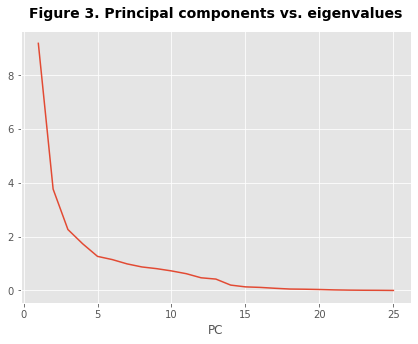

In [39]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
pca_df = pd.DataFrame({'Eigenvalue':pca.explained_variance_, 'PC':list(range(1, pca.n_components_ + 1))})
pca_df.plot.line(x = 'PC', y = 'Eigenvalue', ax=ax, legend=False)
ax.set_title('Figure 3. Principal components vs. eigenvalues', fontdict={'fontsize': 14, 'fontweight': 'bold'}, pad=13)

The eigenvalue of each principal component indicates how much variance the component explains. To find the correct number of principal components to use in the regression model, the 'knee' in the scree plot above was chosen: in this case, five components were retained.

In [40]:
#Extract five components
X_pc_results = X_pc[:,[0,1,2,3,4]]

Each observation's scores for the first five components were then joined to the categorical features. 

In [41]:
#Create data frame with PC scores attached to each parcel number
X_pc_results_df = pd.DataFrame(X_pc_results, index=X.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

#Create data frame with only categorical columns
categoricals = [c for c in X.columns.values if re.search('category_code_description|building_condition', c)]
X_cat = X[categoricals]

X_LR = pd.merge(X_cat, X_pc_results_df, left_index=True, right_index=True)

To avoid the dummy variable trap in regression models, one level was dropped from each categorical variable.

In [42]:
#Drop one level for each dummy variable
X_LR.drop(columns=['category_code_description_Single Family', 'building_condition_14'], inplace=True)

As the variance inflation factor (VIF) results below show, no features are highly correlated. 

In [43]:
#VIF test
VIF = [variance_inflation_factor(X_LR.values, i) for i in range(len(X_LR.columns))]
pd.Series(VIF, index=X_LR.columns)

category_code_description_Commercial                                       1.0842
category_code_description_Industrial                                       1.0335
category_code_description_Mixed Use                                        1.0635
category_code_description_Multi Family                                     1.1316
building_condition_0                                                       1.0043
building_condition_1                                                       1.0074
building_condition_2                                                       1.8306
building_condition_4                                                       1.0325
building_condition_5                                                       1.0003
building_condition_6                                                       1.0599
building_condition_7                                                       1.0080
building_condition_8                                                       1.2369
building_conditi

One 

### 2. Fitting logistic regression model, using principal components and categorical features

To evaluate model performance, predictors and outcome variables were split into training and testing subsets. Models were trained on the former dataset, then evaluated based on how well they predicted labels in the latter dataset.

In [44]:
#Split into test and train datasets
X_LR_train, X_LR_test, Y_LR_train, Y_LR_test = train_test_split(X_LR, Y, random_state=51)

While the LR classifier has no hyperparameters to tune, the RF classifier does. Therefore, half of the testing set for the RF classifier will need to be used as a validation set. To ensure that both models are tested on the same observations, this validation-testing split will be replicated for the LR model.

In [45]:
#Split test set into dev set
X_LR_dev, X_LR_test, Y_LR_dev, Y_LR_test = train_test_split(X_LR_test, Y_LR_test, test_size=0.5, random_state=51)

The sklearn library's logistic regression method was used, as its "class_weight" parameter can be set to account for class imbalance — a noticeable feature of the demolition data.

In [46]:
lr = LogisticRegression(class_weight='balanced', random_state=51, max_iter=1000)
lr.fit(X_LR_train, Y_LR_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=51)

In [47]:
lr_pred = lr.predict(X_LR_test)

### 3. Fitting Random Forest classifier

The full dataset was used for the RF classifier, as unlike logistic regression, the RF algorithm does not require a lack of multicollinearity between predictors. A new training set was thus generated. However, since the same initialisation seed was used for the logistic regression training set, the same observations were used for training and testing. 

In [48]:
X_RF_train, X_RF_test, Y_RF_train, Y_RF_test = train_test_split(X, Y, random_state=51)

#### Tuning number of decision trees

The performance of RF classifiers depends in part on the number of decision trees used to make predictions, the optimal value of which was found through evaluating different values on a validation set. Due to the heavy class imbalance, hyperparameter values were evaluated based on the model's F1 score: the balance between how many positive predictions are actually positive, and how many true positives were predicted as such. Using the accuracy score — the default metric — may privilege models that never predict demolition.

The code for tuning hyperparameters has been commented out, as it takes several minutes to run. Using this process, the best F1 score was 0.0731 (still fairly low), with 160 as the best number of decision trees.

In [49]:
#Split test set into dev set
X_RF_dev, X_RF_test, Y_RF_dev, Y_test = train_test_split(X_RF_test, Y_RF_test, test_size=0.5, random_state=51)

In [50]:
# number of trees to tune
#no_trees = [100,120,140,160,180,200,220]

#max_score = 0
#best_no_trees = None
#for t in no_trees:
#    m = RandomForestClassifier(n_estimators=t, class_weight='balanced', random_state=51).fit(X_RF_train, Y_RF_train)
#    t_pred = m.predict(X_RF_dev)
#    score = f1_score(Y_RF_dev, t_pred)
#    if score > max_score:
#        max_score = score
#        best_no_trees = t

In [51]:
#max_score

In [52]:
#best_no_trees

The RF classifier was then fitted using the optimal number of trees.

In [53]:
rf = RandomForestClassifier(n_estimators=160, class_weight='balanced', random_state=51)
rf.fit(X_RF_train, Y_RF_train)

RandomForestClassifier(class_weight='balanced', n_estimators=160,
                       random_state=51)

In [54]:
rf_pred = rf.predict(X_RF_test)

## Results and Discussion

### Principal component logistic regression

In [55]:
print(classification_report(Y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      8896
           1       0.03      0.52      0.05        82

    accuracy                           0.82      8978
   macro avg       0.51      0.67      0.47      8978
weighted avg       0.99      0.82      0.89      8978



[Text(0.5, 15.0, 'Predicted value'), Text(33.0, 0.5, 'True value')]

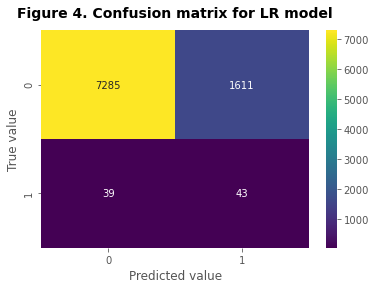

In [56]:
lr_mat = confusion_matrix(Y_test, lr_pred)
lr_mat_plot = sns.heatmap(lr_mat, annot=True, cmap='viridis', fmt='g')
lr_mat_plot.set_title('Figure 4. Confusion matrix for LR model', fontdict={'fontsize': 14, 'fontweight': 'bold'}, pad=13)
lr_mat_plot.set(xlabel='Predicted value', ylabel='True value')

### RF classifier

In [57]:
print(classification_report(Y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8896
           1       0.78      0.09      0.15        82

    accuracy                           0.99      8978
   macro avg       0.88      0.54      0.57      8978
weighted avg       0.99      0.99      0.99      8978



[Text(0.5, 15.0, 'Predicted value'), Text(33.0, 0.5, 'True value')]

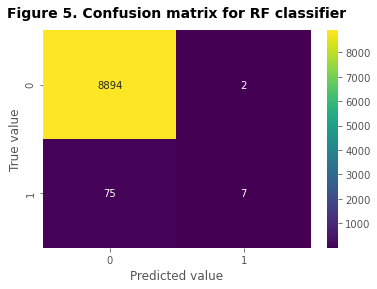

In [58]:
rf_mat = confusion_matrix(Y_test, rf_pred)
rf_mat_plot = sns.heatmap(rf_mat, annot=True, cmap='viridis', fmt='g')
rf_mat_plot.set_title('Figure 5. Confusion matrix for RF classifier', fontdict={'fontsize': 14, 'fontweight': 'bold'}, pad=13)
rf_mat_plot.set(xlabel='Predicted value', ylabel='True value')

The models predict demolition at vastly different rates. The RF model significantly _underpredicts_ demolitions: only 9% of properties with a demolition permit issued betweeen 2018 and 2021 were correctly classified as such. By contrast, the LR model _overpredicts_ demolitions: of the properties predicted to be associated with a demolition permit, only 3% actually did. 

Overall, however, the RF classifier appears to perform slightly better than the LR model. While the RF model predicted the correct demolition status for 99% of properties, the principal component LR model only did so for 82% of properties. Additionally, the low precision of the LR model with regards to predicting demolitions is not accompanied by high recall, as is typically the case: only 52% of properties with actual demolition permits were correctly predicted as such. 

Still, the RF model may not be of much use for predicting future demolitions. The recall score for predicting demolitions is still too low for policymakers to obtain justified estimates of future demolition activity — an unsurprising result given the extremely low proportion of properties with associated demolition permits. While collecting data on demolished buildings over a longer time frame could improve model performance, comprehensive building-level data on long-demolished properties is unavailable. Additionally, there is evidence to suggest that Covid-19 influenced property-market trends in Philadelphia (Allen and Briggs, 2020), reducing the utility of a predictive model trained before the pandemic. 

## Conclusion

This report sought to identify how Philadelphia policymakers could best predict building demolition risk, evaluating two classification methods that account for the complex interactions between property and neighbourhood characteristics. Given the lack of data on demolished buildings for model training, neither of the two approaches tested in this report would provide useful information for planning decisions. 

If policymakers and advocates in Philadelphia want to utilize predictive modelling for analysing future demolition activity, there are two potential routes for doing so. The first is advocating for the City to provide more comprehensive historical data on properties, which would partially mitigate the class-imbalance issue that hampered model performance. The second is exploring advanced anomaly-detection algorithms, which are calibrated for rare events (Ruiz and Villa, 2008). 

## References

Allen, T. and Briggs, R. (no date). ‘Demolition in Philly dropped by half in 2020 — Is that a good thing?’ WHYY. Available at: https://whyy.org/articles/demolition-in-philly-dropped-by-half-in-2020-is-that-a-good-thing/ (Accessed: 9 May 2021).

Blumgart, J. (2019). ‘Why so few of Philadelphia’s old buildings are historically protected’. WHYY, 16 April. Available at: https://whyy.org/episodes/why-so-few-of-philadelphias-buildings-are-historically-protected/ (Accessed: 7 May 2021).

Briggs, R. (2018). ‘Philadelphia demolitions hit record high in 2018’. WHYY, 28 December. Available at: https://whyy.org/articles/philadelphia-demolitions-hit-record-high-in-2018/ (Accessed: 7 May 2021).

Briggs, R. (2019). ‘Philadelphia’s building boom spawned a demolition boom in 2019’. WHYY, 19 December. Available at: https://whyy.org/articles/philadelphias-building-boom-spawned-a-demolition-boom-in-2019/ (Accessed: 7 May 2021).

Charles, S. L. (2013). ‘Understanding the Determinants of Single-family Residential Redevelopment in the Inner-ring Suburbs of Chicago’. Urban Studies. SAGE Publications Ltd, 50 (8), pp. 1505–1522. doi: 10.1177/0042098012465908.

Charles, S. L. (2014). ‘The spatio-temporal pattern of housing redevelopment in suburban Chicago, 2000–2010’. Urban Studies. SAGE Publications Ltd, 51 (12), pp. 2646–2664. doi: 10.1177/0042098013506045.

City of Philadelphia Office of Property Assessment (2021). ‘Philadelphia Properties and Assessment History.’ Available at: https://www.opendataphilly.org/dataset/opa-property-assessments (Accessed: 26 April 2021).

Ding, L., Hwang, J. and Divringi, E. (2016). ‘Gentrification and residential mobility in Philadelphia’. Regional Science and Urban Economics, 61, pp. 38–51. doi: 10.1016/j.regsciurbeco.2016.09.004.

Dubé, J., Desaulniers, S., Bédard, L.-P., Binette, A. and Leblanc, E. (2018). ‘Urban residential reconversion through demolition: A land use model based on administrative spatial micro-data’. Land Use Policy, 76, pp. 686–696. doi: 10.1016/j.landusepol.2018.02.052.

Dye, R. F. and McMillen, D. P. (2007). ‘Teardowns and land values in the Chicago metropolitan area’. Journal of Urban Economics, 61 (1), pp. 45–63. doi: 10.1016/j.jue.2006.06.003.

Jolliffe, I. T. and Cadima, J. (2016). ‘Principal component analysis: a review and recent developments’. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences. Royal Society, 374 (2065), p. 20150202. doi: 10.1098/rsta.2015.0202.

Maule, B. (2019). As Jewelers’ Row is demolished, where was Mayor Kenney’s leadership? | Opinion. https://www.inquirer.com. Available at: https://www.inquirer.com/opinion/commentary/jewelers-row-historic-preservation-toll-brothers-mayor-jim-kenney-20191120.html (Accessed: 7 May 2021).

Munneke, H. J. (1996). ‘Redevelopment Decisions for Commercial and Industrial Properties’. Journal of Urban Economics, 39 (2), pp. 229–253. doi: 10.1006/juec.1996.0013.

Nguyen, L. H. and Holmes, S. (2019). ‘Ten quick tips for effective dimensionality reduction’. PLoS Computational Biology, 15 (6). doi: 10.1371/journal.pcbi.1006907.

Reades, J., De Souza, J. and Hubbard, P. (2019). ‘Understanding urban gentrification through machine learning’. Urban Studies. SAGE Publications Ltd, 56 (5), pp. 922–942. doi: 10.1177/0042098018789054.

Ruiz, A. and Villa, N. (2008). ‘Storms prediction : Logistic regression vs random forest for unbalanced data’. arXiv:0804.0650 [math, stat]. Available at: http://arxiv.org/abs/0804.0650 (Accessed: 9 May 2021).

Saffron, I. (2021). Graduate Hospital teardown tells us about affordability and tax policy in Philadelphia. Available at: https://www.inquirer.com/real-estate/inga-saffron/graduate-hospital-teardown-demolition-architecture-history-preservation-zatos-stamm-gnome-south-philadelphia-density-yimby-20210227.html (Accessed: 10 May 2021).

Southeastern Pennsylvania Transportation Authority (2018). ‘SEPTA - Broad Street Line Stations.’ Available at: https://septaopendata-septa.opendata.arcgis.com/datasets/septa-broad-street-line-stations?geometry=-75.402%2C39.928%2C-74.908%2C40.020 (Accessed: 1 May 2021). 

Southeastern Pennsylvania Transportation Authority (2018). ‘SEPTA - Market-Frankford Line Stations.’ Available at: https://septaopendata-septa.opendata.arcgis.com/datasets/8c6e2575c8ad46eb887e6bb35825e1a6_0?geometry=-75.416%2C39.940%2C-74.922%2C40.032 (Accessed: 1 May 2021). 

Southeastern Pennsylvania Transportation Authority (2018). ‘SEPTA - Regional Rail Stations.’ Available at: https://septaopendata-septa.opendata.arcgis.com/datasets/septa-regional-rail-stations?geometry=-77.235%2C39.620%2C-73.282%2C40.356 (Accessed: 1 May 2021). 

Southeastern Pennsylvania Transportation Authority (2018). ‘SEPTA - Trolley Stops.’ Available at: https://septaopendata-septa.opendata.arcgis.com/datasets/septa-trolley-stops?geometry=-75.488%2C39.906%2C-74.993%2C39.998 (Accessed: 1 May 2021). 

U.S. Census Bureau (2018). ’2013-2018 American Community Survey 5-year estimates.’ Available at: https://api.census.gov/data/2018/acs/acs5.html (Accessed: 26 April 2021). 

Weber, R., Doussard, M., Bhatta, S. D. and Mcgrath, D. (2006). ‘Tearing the City Down: Understanding Demolition Activity in Gentrifying Neighborhoods’. Journal of Urban Affairs. Routledge, 28 (1), pp. 19–41. doi: 10.1111/j.0735-2166.2006.00257.x.